In [73]:
import numpy as np
import sys
sys.path.append("/users/tom/git/neon_blink_detection/")

from training.video_loader import video_loader
from src.helper import OfParams
from pathlib import Path
from src.neon_blink_detector import detect_blinks
import typing as T
from helper import OfParams, PPParams, AugParams
from post_processing import post_process
from xgboost import XGBClassifier
from pathlib import Path
import joblib
from features_calculator import calculate_optical_flow, concatenate_features, create_grids
from utils import resize_images, rotate_images

video_path = Path("/users/tom/experiments/neon_blink_detection/datasets/train_data")
of_path = Path("/users/tom/experiments/neon_blink_detection/datasets/train_data/optical_flow")

of_params = OfParams()

clip_names = [
    "2023-03-01_09-59-07-2ea49126",  # kai bike
    "2023-01-27_15-59-54-49a115d5",  # tom computer
    "2023-02-01_11-45-11-7621531e",  # kai computer
    "2023-01-27_16-10-14-a2a8cbe1",  # ryan discussing
    "2023-01-27_16-15-26-57802f75",  # tom walking
    "2023-01-27_16-24-04-eb4305b1",  # kai walking
    "2023-01-27_16-31-52-5f743ed0",  # moritz snowboarding
    "padel_tennis_neon_01-b922b245",  # mgg padel
    "padel_tennis_neon_03-2ded8f56",  # mgg partner padel
]


def get_params() -> T.Tuple[OfParams, PPParams]:
    """Get optical flow parameters and post processing parameters."""

    of_params = OfParams(5, 7, False, (64, 64), 4, 7, 15, 3)
    pp_params = PPParams(
        max_gap_duration_s=0.03,
        short_event_min_len_s=0.1,
        smooth_window=11,
        proba_onset_threshold=0.25,
        proba_offset_threshold=0.25,
    )
    
    aug_params = AugParams()
    return of_params, pp_params

def get_classifier(clf_path: Path) -> XGBClassifier:
    """Get classifier with weights."""

    return joblib.load(str(clf_path))


iclip = 8


In [74]:


of_params, pp_params = get_params()

aug_params = AugParams()

of_params.n_layers = 5
of_params.layer_interval = 7
of_params.grid_size = 4
of_params.window_size = 15

clf = get_classifier("/users/tom/git/neon_blink_detection/weights/xgb.sav")

rec = video_loader(of_params, aug_params)
ts, images_left, images_right = rec._get_frames_pyav(clip_names[iclip], convert_to_gray=True)

times = (ts - ts[0]) / 1e9
# times = np.arange(0, len(ts)) / 200.0
blink_df = rec._load_gt_labels(clip_names[iclip])

grid = create_grids(of_params.img_shape, of_params.grid_size+2, full_grid=False)
images_left, images_right = resize_images(images_left, images_right, of_params.img_shape)

feature_array, _ = calculate_optical_flow(of_params, images_left, images_right, grids=grid)

features = concatenate_features(feature_array, of_params)
proba = clf.predict_proba(features)
blink_events = post_process(ts, proba, pp_params)


In [75]:
from src.utils import resize_images

left_images, right_images = resize_images(
    images_left, images_right, img_shape=(64, 64)
)

blink_ts = blink_df[blink_df["label"]=="onset"]["start_ts"]
blink_on_idx = np.where(np.isin(ts, blink_ts))[0]
blink_ts = blink_df[blink_df["label"]=="offset"]["end_ts"]
blink_off_idx = np.where(np.isin(ts, blink_ts))[0]


img_left = np.concatenate([left_images[blink_on_idx[x]: blink_off_idx[x], :, :] for x in range(len(blink_on_idx))])
img_right = np.concatenate([right_images[blink_on_idx[x]: blink_off_idx[x], :, :] for x in range(len(blink_on_idx))])

predicted_blink_on = np.array([np.where(np.isin(ts, blink_events[x].start_time))[0][0] for x in range(len(blink_events))])

predicted_blink_off = np.array([np.where(np.isin(ts, blink_events[x].end_time))[0][0] for x in range(len(blink_events))])


In [76]:
def compute_iou(event1, event2):
    start1, end1 = event1
    start2, end2 = event2
    intersection_start = max(start1, start2)
    intersection_end = min(end1, end2)
    intersection_length = max(0, intersection_end - intersection_start)
    
    union_start = min(start1, start2)
    union_end = max(end1, end2)
    union_length = union_end - union_start

    return intersection_length / union_length


def compute_multiple_iou(ground_truth_events, predicted_events, iou_threshold=0.2):
    ground_truth_indices = set(range(len(ground_truth_events)))
    predicted_indices = set(range(len(predicted_events)))
    iou_results = []

    for gt_index, gt_event in enumerate(ground_truth_events):
        for pred_index, pred_event in enumerate(predicted_events):
            iou = compute_iou(gt_event, pred_event)
            if iou > iou_threshold:
                iou_results.append((gt_index, pred_index, iou))
                if gt_index in ground_truth_indices:
                    ground_truth_indices.remove(gt_index)
                if pred_index in predicted_indices:
                    predicted_indices.remove(pred_index)

    false_negatives = [(i, ground_truth_events[i]) for i in ground_truth_indices]
    false_positives = [(i, predicted_events[i]) for i in predicted_indices]

    return iou_results, false_negatives, false_positives


In [77]:
pred = [(predicted_blink_on[x], predicted_blink_off[x]) for x in range(len(predicted_blink_on))]

gt = [(blink_on_idx[x], blink_off_idx[x]) for x in range(len(blink_on_idx))]

iou_results, false_negatives, false_positives = compute_multiple_iou(gt, pred, iou_threshold=0.2)

# false_positives[3][1][0] / 200 + blink_df[blink_df["label"]=="clip_trigger"]["start_t"].iloc[0]

# false_negatives[0][1][0] / 200

false_positives

[(13, (2618, 2649)), (20, (4169, 4199))]

**CREATE VIDEO OF FALSE POSITIVES**

In [78]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

for i in range(len(false_positives)):

    fig, axs = plt.subplots(1, 2)

    video_left = images_left[false_positives[i][1][0]:false_positives[i][1][1],:,:]
    video_right = images_right[false_positives[i][1][0]:false_positives[i][1][1],:,:]

    fig.set_size_inches(8, 4)
    im0 = axs[0].imshow(video_left[0, :, :], cmap='gray')
    im1 = axs[1].imshow(video_right[0, :, :], cmap='gray')
    axs[0].axis("off")
    axs[1].axis("off")

    plt.close() # this is required to not display the generated image

    def init():
        im0.set_data(video_left[0,:,:])
        im1.set_data(video_right[0,:,:])

    def animate(frame):
        im0.set_data(video_left[frame,:,:])
        im1.set_data(video_right[frame,:,:])

        return im0, im1

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video_left.shape[0], interval=25)

    anim.save('/users/tom/blink_videos/FP%d_rec%s.mp4' %(i, clip_names[iclip]), extra_args=['-vcodec', 'libx264'])

    HTML(anim.to_html5_video())

**CREATE VIDEO OF FALSE NEGTIVES**

In [79]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

for i in range(len(false_negatives)):

    fig, axs = plt.subplots(1, 2)

    video_left = images_left[false_negatives[i][1][0]:false_negatives[i][1][1],:,:]
    video_right = images_right[false_negatives[i][1][0]:false_negatives[i][1][1],:,:]

    fig.set_size_inches(8, 4)
    im0 = axs[0].imshow(video_left[0, :, :], cmap='gray')
    im1 = axs[1].imshow(video_right[0, :, :], cmap='gray')
    axs[0].axis("off")
    axs[1].axis("off")

    plt.close() # this is required to not display the generated image

    def init():
        im0.set_data(video_left[0,:,:])
        im1.set_data(video_right[0,:,:])

    def animate(frame):
        im0.set_data(video_left[frame,:,:])
        im1.set_data(video_right[frame,:,:])

        return im0, im1

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video_left.shape[0],interval=25)

    anim.save('/users/tom/blink_videos/FN%d_rec%s.mp4' %(i, clip_names[iclip]),extra_args=['-vcodec', 'libx264'])

    HTML(anim.to_html5_video())

In [64]:
blink_ts = blink_df[blink_df["label"]=="onset"]["start_ts"]
blink_on_idx = np.where(np.isin(ts, blink_ts))[0]
blink_ts = blink_df[blink_df["label"]=="offset"]["end_ts"]
blink_off_idx = np.where(np.isin(ts, blink_ts))[0]

predicted_blink_on = np.array([np.where(np.isin(ts, blink_events[x].start_time))[0][0] for x in range(len(blink_events))])
predicted_blink_off = np.array([np.where(np.isin(ts, blink_events[x].end_time))[0][0] for x in range(len(blink_events))])

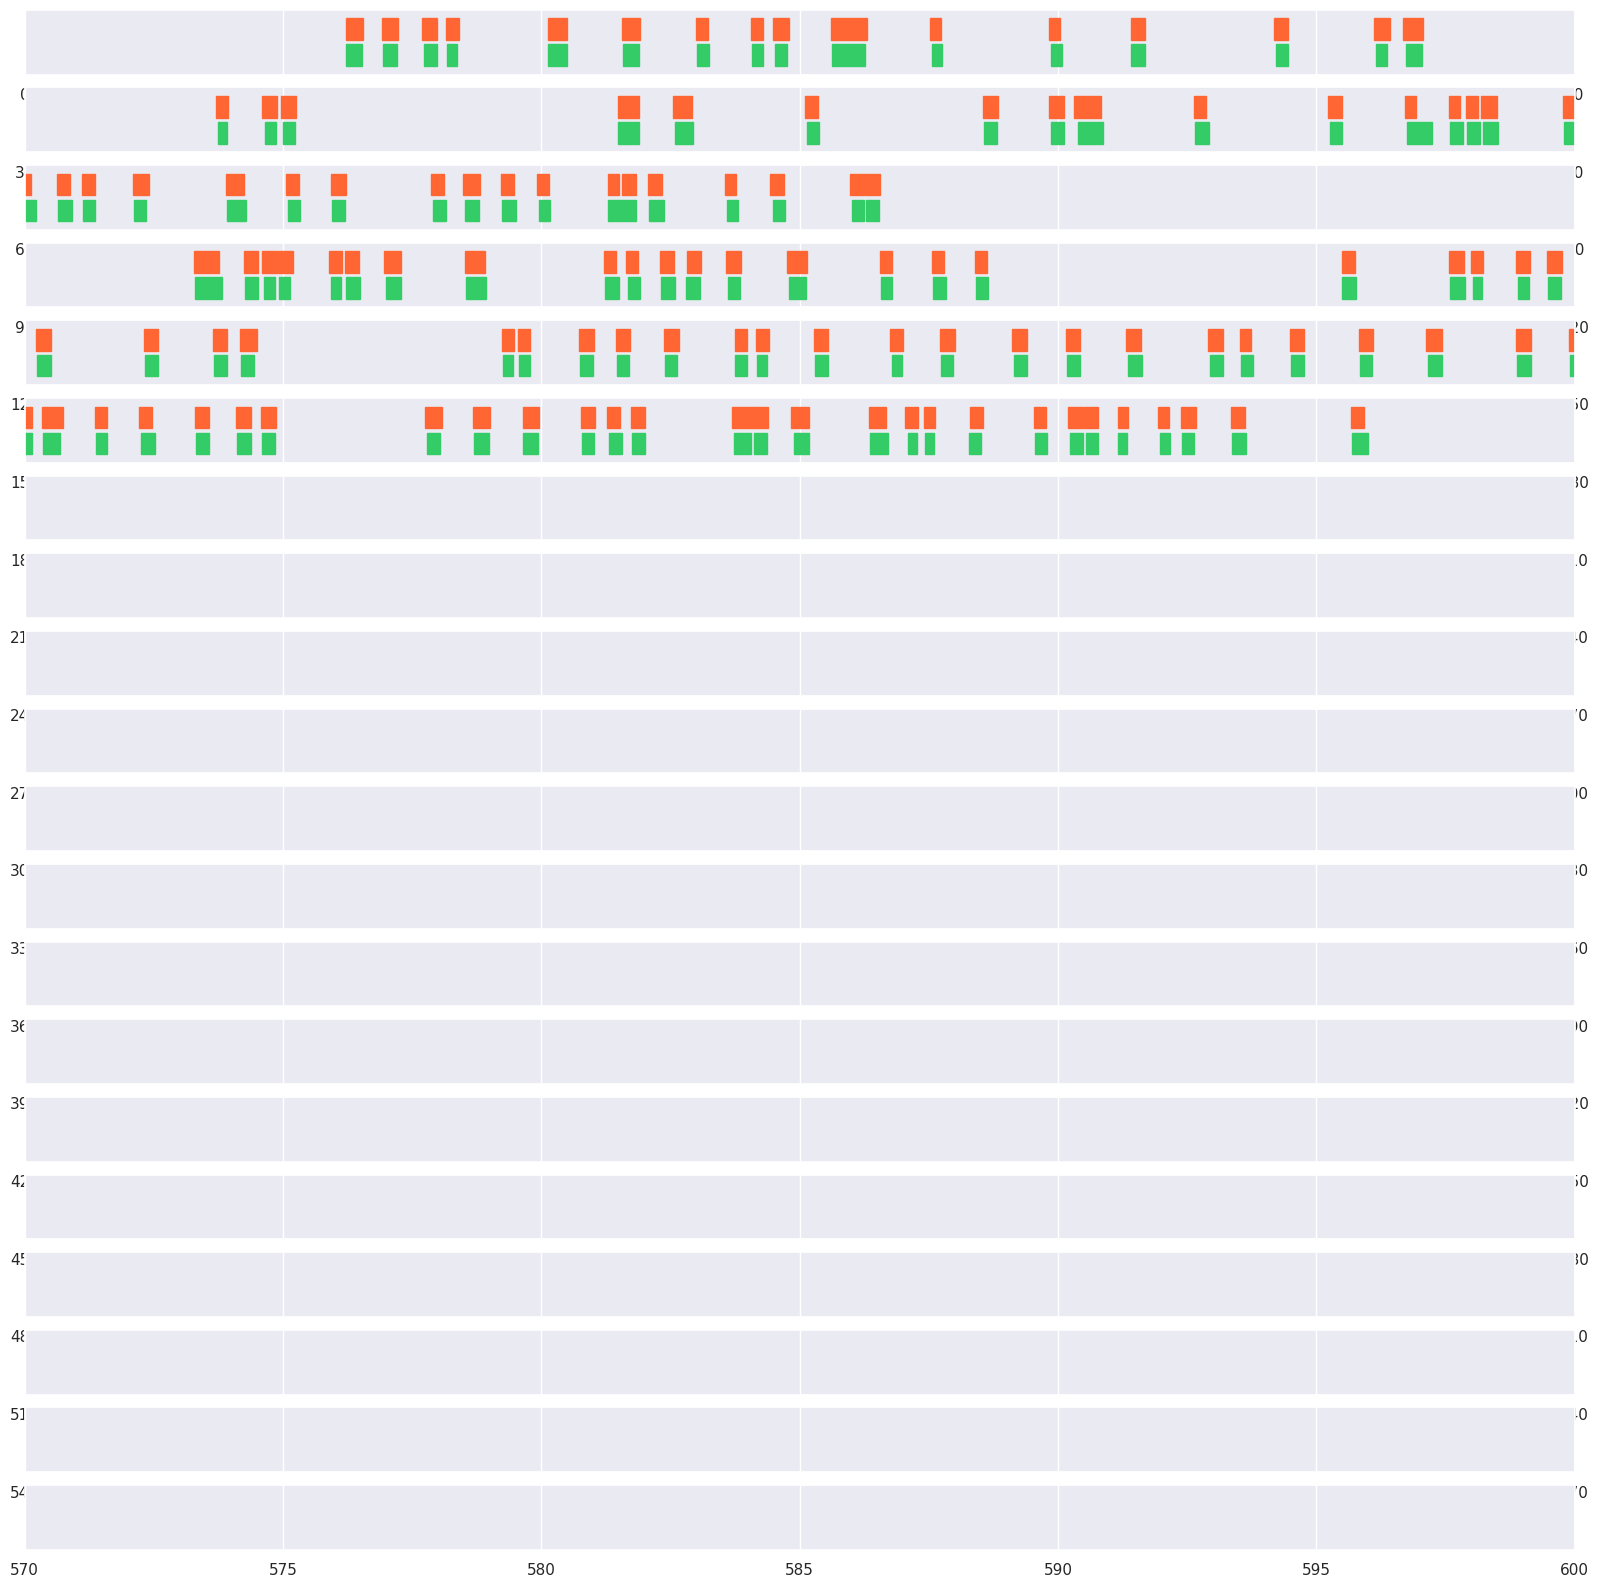

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib.patches import Rectangle

def render_event_array(ax, blink_on_idx, blink_off_idx, y, color):
    # flags = np.ones(len(legend_labels))
    legends = {}

    for i in range(len(blink_on_idx)):
        start = blink_on_idx[i]/200
        end = blink_off_idx[i]/200
        height = 0.5
        patch = Rectangle((start, y), end - start, height, color=color)
        ax.add_patch(patch)
        # legends["blink"] = patch

    ax.set_yticks([])
    ax.set_ylim(0, 1.5)

def create_subplot(ax, on_idx, off_idx, pred_on, pred_off, start, end, colors):
    render_event_array(ax, on_idx, off_idx, 0.2, color=colors[0])
    render_event_array(ax, pred_on, pred_off, 0.8, color=colors[1])
    ax.set_xlim(start, end)

f, ax = plt.subplots(20, 1)
f.set_size_inches(20, 20)

colors = [[0.2, 0.8, 0.4], [1, 0.4, 0.2]]
time_intervals = [(i * 30, (i + 1) * 30) for i in range(20)]

for i, (start, end) in enumerate(time_intervals):
    create_subplot(ax[i], blink_on_idx, blink_off_idx, predicted_blink_on, predicted_blink_off, start, end, colors)


In [114]:
blink_on_idx

array([   58,   317,   664,  1549,  2771,  3985,  5193,  6450,  8802,
       10001, 10995, 11043, 13830, 14331, 15076, 15312, 16010, 16180,
       16536, 16644, 16780, 19388, 22053, 22898, 23052, 23181, 23631,
       25420, 25739, 25892, 26032, 26071, 27461, 34174, 34276, 35095,
       35658, 38738, 40672, 44049, 44462, 44553])

In [31]:
ts.shape[0]/200

69.06

IndexError: index 0 is out of bounds for axis 0 with size 0

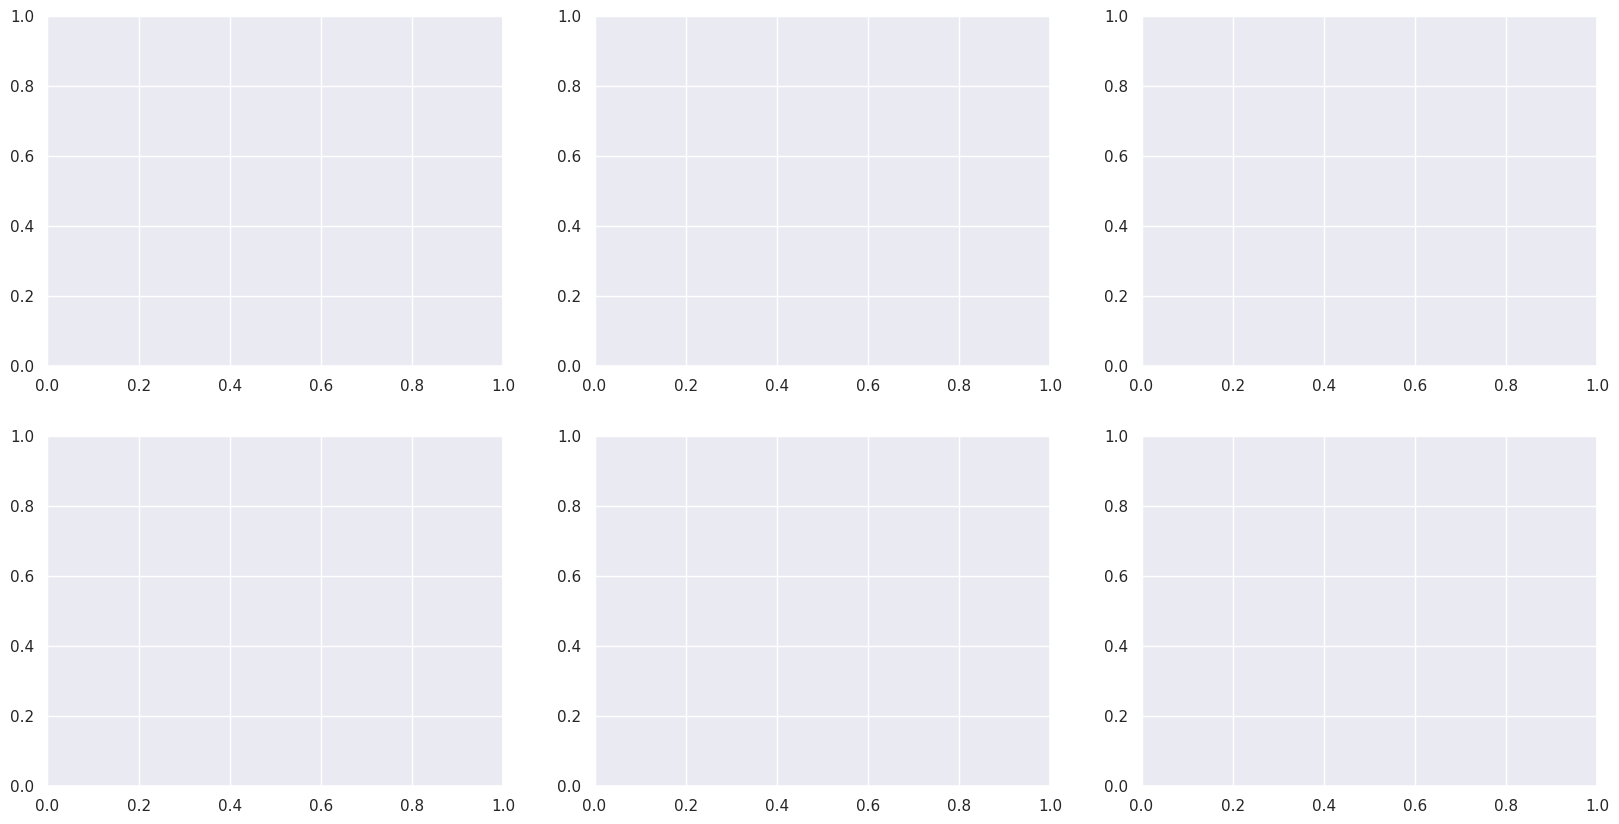

In [19]:

import matplotlib.pyplot as plt
from post_processing import smooth_proba
import seaborn as sns
cols = sns.color_palette(palette=None, n_colors=2)

f, ax = plt.subplots(2, 3)
ax = np.concatenate(ax)

f.set_size_inches(20, 10)

sm_proba = smooth_proba(proba, pp_params)

[ax[x].plot(sm_proba[MISS_on[x]-30:MISS_on[x]+80, 1:], linestyle="-") for x in range(len(ax))]
[ax[x].set_prop_cycle(None) for x in range(len(ax))]

[ax[x].plot(proba[MISS_on[x]-30:MISS_on[x]+80, 1:], linestyle=":") for x in range(len(ax))]

[ax[x].vlines(30, 0, 1, color=[0.7, 0.7, 0.7], linestyle="-") for x in range(len(ax))]
[ax[x].hlines(0.25, 0, 120, color=[0.7, 0.7, 0.7], linestyle=":") for x in range(len(ax))]

[ax[x].set_xticks([0, 30, 60, 90, 120], [-150, 0, 150, 300, 450]) for x in range(len(ax))]

ax[0].legend(["Onset", "Offset"])

[ax[x].set_xlabel("Time from blink onset [ms]") for x in (3+np.arange(3))]
[ax[x].set_ylabel("Probability") for x in [0, 3]]

blink_on_idx = np.array(blink_df[blink_df["label"] == "onset"].iloc[[0, 1 ,2 ,3, 5, 6], :]["start_ts"])

blink_idc = np.where(np.isin(ts, blink_on_idx))[0]

f, ax = plt.subplots(2, 3)
ax = np.concatenate(ax)

f.set_size_inches(20, 10)

[ax[x].plot(proba[blink_idc[x]-30:blink_idc[x]+80, 1:], linestyle=":") for x in range(len(ax))]
[ax[x].set_prop_cycle(None) for x in range(len(ax))]
[ax[x].plot(sm_proba[blink_idc[x]-30:blink_idc[x]+80, 1:]) for x in range(len(ax))]

[ax[x].vlines(30, 0, 1, color=[0.7, 0.7, 0.7], linestyle="--") for x in range(len(ax))]
[ax[x].hlines(0.25, 0, 120, color=[0.7, 0.7, 0.7], linestyle=":") for x in range(len(ax))]
[ax[x].set_xticks([0, 30, 60, 90, 120], [-150, 0, 150, 300, 450]) for x in range(len(ax))]
ax[0].legend(["Onset", "Offset"])

[ax[x].set_xlabel("Time from blink onset [ms]") for x in (3+np.arange(3))]
[ax[x].set_ylabel("Probability") for x in [0, 3]]

blink_on_idx = np.array(blink_df[blink_df["label"] == "onset"].iloc[[0, 1 ,2 ,3, 5, 6], :]["start_ts"])



In [122]:
from training.run_one import evaluate_clips



ModuleNotFoundError: No module named 'video_loader'

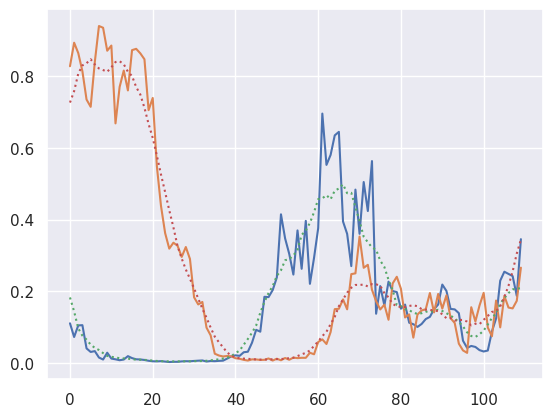

In [48]:
plt.plot(proba[MISS_on[0]-30:MISS_on[0]+80, 1:], linestyle="-")
f.gca().set_prop_cycle(None)
plt.plot(sm_proba[MISS_on[0]-30:MISS_on[0]+80, 1:], linestyle=":")


In [33]:
from src.utils import resize_images

left_images, right_images = resize_images(
    images_left, images_right, img_shape=(64, 64)
)

def render_video(video):

    %matplotlib inline
    from matplotlib import pyplot as plt
    from matplotlib import animation

    fig, axs = plt.subplots(1,1)
    im0 = axs.imshow(video[0,:,:], cmap='gray')
    axs.axis("off")

    plt.close() 

    def init():
        im0.set_data(video[0,:,:])

    def animate(i):
        im0.set_data(video[i,:,:])
        return im0

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                                interval=5)

    return anim

In [106]:
blink_on_idx/200

array([ 2.815,  4.25 ,  5.85 ,  6.385,  6.865,  7.62 , 10.725, 11.315,
       12.73 , 13.895, 15.815, 16.365, 19.655, 21.09 , 21.53 , 23.555,
       27.065, 30.555, 32.635, 34.97 , 35.65 , 35.785, 37.225, 38.085,
       42.775, 44.845, 47.235, 49.99 , 53.49 , 55.16 , 55.705, 55.905,
       56.1  ])

In [15]:
left_images, right_images = resize_images(
    images_left, images_right, img_shape=(64, 64)
)
left_images.shape

(11349, 64, 64)

In [186]:
x = np.linspace(0, 2, 5)
y = np.linspace(0, 2, 5)

X, Y = np.meshgrid(x, y)
grid = np.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1)), axis=1)


In [191]:
g = np.zeros([grid.shape[0], 3])
g[:, 0] = grid[:, 0]
g[:, 1] = grid[:, 1]
g[:, 2] = 1

grid = g

array([1676312542582899469, 1676312543653906469, 1676312544429661469,
       1676312545000164469, 1676312545961046469, 1676312546441549469],
      dtype=object)

(-1.0, 3.0)

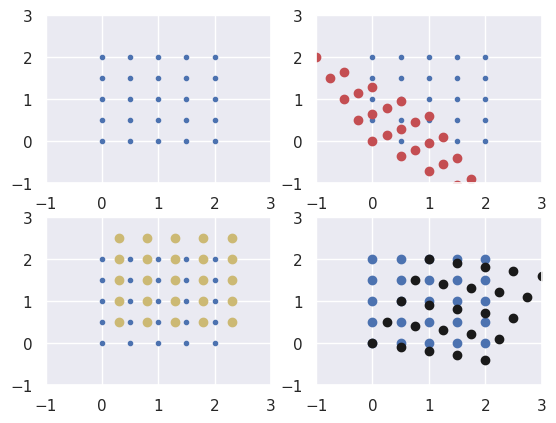

In [217]:
f, ax = plt.subplots(2, 2)

ax[0, 0].plot(grid[:, 0], grid[:, 1], "b.")
ax[0, 0].set_xlim(-1, 3)
ax[0, 0].set_ylim(-1, 3)

T = np.array([[1, -0.5, 0], [-0.7, 1, 0], [0, 0, 1]])
new_grid = np.matmul(grid, T.T)
ax[0, 1].plot(grid[:, 0], grid[:, 1], "b.")
ax[0, 1].plot(new_grid[:, 0], new_grid[:, 1], "ro")
ax[0, 1].set_xlim(-1, 3)
ax[0, 1].set_ylim(-1, 3)

T = np.array([[1, 0, 0.3], [0, 1, 0.5], [0, 0, 1]])
new_grid = np.matmul(grid, T.T)
ax[1, 0].plot(grid[:, 0], grid[:, 1], "b.")
ax[1, 0].plot(new_grid[:, 0], new_grid[:, 1], "yo")
ax[1, 0].set_xlim(-1, 3)
ax[1, 0].set_ylim(-1, 3)

T = np.array([[1, 0.5, 0], [-0.2, 1, 0], [0, 0, 1]])
new_grid = np.matmul(grid, T.T)
ax[1, 1].plot(grid[:, 0], grid[:, 1], "bo")
ax[1, 1].plot(new_grid[:, 0], new_grid[:, 1], "ko")
ax[1, 1].set_xlim(-1, 3)
ax[1, 1].set_ylim(-1, 3)



In [219]:
features = np.random.random([8000,800,2])


In [220]:
griddata(grid, features, transf_grid, method="linear")

(8000, 800, 2)

In [224]:
grid_size = 20
of_grid = create_grids((64, 64), grid_size, full_grid=True)
of_grid = np.concatenate(2 * [of_grid])

In [237]:
of_grid = np.hstack((of_grid, np.ones((of_grid.shape[0],1))))

In [285]:
T = np.array([[1, 0.01, 0], [0.1, 1, 0], [0, 0, 1]])
T = np.tile(T, (100, 1, 1)).shape

new_grid = np.matmul(of_grid, T)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

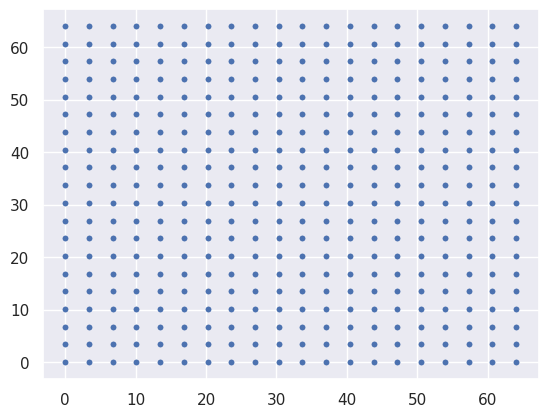

In [286]:
plt.plot(of_grid[:, 0], of_grid[:, 1], "b.")
plt.plot(new_grid[:, 0], new_grid[:, 1], "ro")

In [287]:
new_grid.shape

(800,)

In [274]:
of_grid.shape

(800, 3)

In [139]:
proba[0:50, 0]


array([0.99669445, 0.99588084, 0.9950259 , 0.9941376 , 0.9932236 ,
       0.99229157, 0.9916925 , 0.99116683, 0.9907199 , 0.9903555 ,
       0.99007636, 0.98988366, 0.98973984, 0.9896365 , 0.9895656 ,
       0.98951876, 0.9894878 , 0.9894633 , 0.98944026, 0.98941386,
       0.98938006, 0.98933476, 0.98927474, 0.9891973 , 0.9891003 ,
       0.9889817 , 0.9888414 , 0.9886802 , 0.98850065, 0.9883067 ,
       0.98810375, 0.9878977 , 0.9876952 , 0.9875037 , 0.9873304 ,
       0.98718196, 0.9870644 , 0.98698133, 0.98693454, 0.98692316,
       0.9869447 , 0.98699456, 0.98706746, 0.987157  , 0.987256  ,
       0.98735696, 0.9874528 , 0.98753697, 0.9876036 , 0.98764896],
      dtype=float32)

In [126]:
smooth_proba[0:50, 0]

array([0.99726945, 0.9965624 , 0.99580467, 0.9950024 , 0.9941623 ,
       0.9932917 , 0.99266845, 0.9920954 , 0.9915812 , 0.9911328 ,
       0.9907561 , 0.99045527, 0.9902057 , 0.9900024 , 0.9898392 ,
       0.98970896, 0.9896037 , 0.989515  , 0.98943675, 0.9893634 ,
       0.98929   , 0.98921245, 0.98912746, 0.9890328 , 0.9889273 ,
       0.9888103 , 0.9886823 , 0.9885446 , 0.988399  , 0.98824847,
       0.98809594, 0.98794514, 0.9877997 , 0.9876633 , 0.9875396 ,
       0.9874315 , 0.9873415 , 0.98727125, 0.98722154, 0.9871921 ,
       0.9871819 , 0.987189  , 0.98721063, 0.9872436 , 0.98728424,
       0.9873288 , 0.98737353, 0.98741496, 0.98745006, 0.9874766 ],
      dtype=float32)

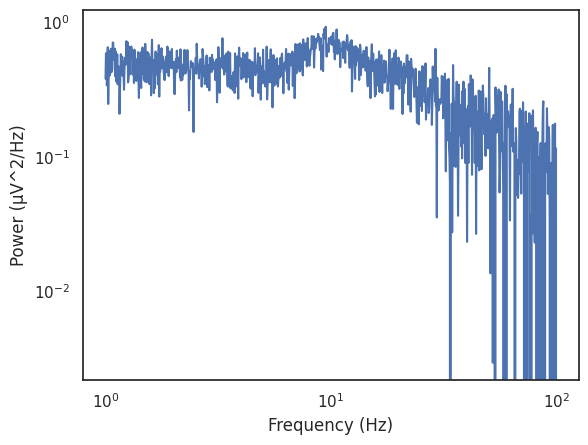

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(123)

# Define frequency range
freqs = np.logspace(0, 2, num=1000)

# Generate simulated power spectrum with noise and peaks
power = 0.5 * np.exp(-freqs / 50) + \
        0.3 * np.exp(-(np.log10(freqs) - np.log10(10)) ** 2 / (2 * 0.1 ** 2)) + \
        0.1 * np.exp(-(np.log10(freqs) - np.log10(20)) ** 2 / (2 * 0.05 ** 2)) + \
        0.1 * np.random.normal(size=len(freqs))

# Plot power spectrum in log-log coordinates
plt.loglog(freqs, power)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (μV^2/Hz)')
plt.show()

(-2.45, 51.45, -0.027909705026897158, 6.129217767287105)

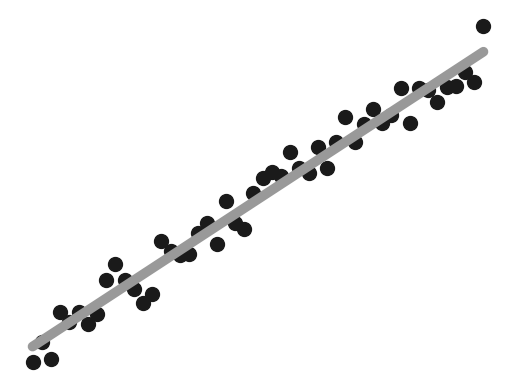

In [41]:
# plot a line with a few random data points around the line (aboive and below)

import numpy as np
import matplotlib.pyplot as plt
sns.set_style("white")

data = np.random.rand(50) + np.arange(0, 50) * 0.1
# fit a line to the data
z = np.polyfit(np.arange(0, 50), data, 1)
p = np.poly1d(z)
# plot the data and the fitted line with large data points
plt.plot(np.arange(0, 50), data, 'ko', ms=10)
plt.plot(np.arange(0, 50), p(np.arange(0, 50)), '-', color = [.6, .6, .6], lw=7)
plt.axis("off")


(-2.45, 51.45, -1.4544096613102058, 6.563926344904587)

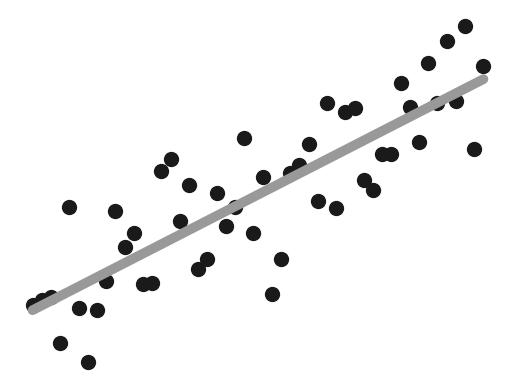

In [62]:
# plot a gaussian distribution with a few random data points around the line (aboive and below)

import numpy as np
import matplotlib.pyplot as plt
sns.set_style("white")

data = np.random.normal(0, 1, 50) + np.arange(0, 50) * 0.1
# fit a line to the data
z = np.polyfit(np.arange(0, 50), data, 1)
p = np.poly1d(z)
# plot the data and the fitted line with large data points
plt.plot(np.arange(0, 50), data, 'ko', ms=10)
plt.plot(np.arange(0, 50), p(np.arange(0, 50)), '-', color = [.6, .6, .6], lw=7)
plt.axis("off")


(0.0, 1.13)

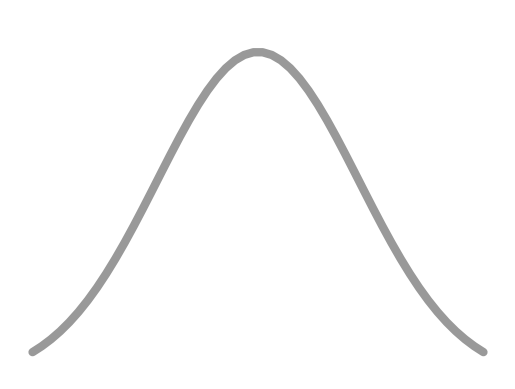

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Set parameters
mu = 5 # mean of the Gaussian distribution
sigma = 1 # standard deviation of the Gaussian distribution
num_samples = 50 # number of samples to generate
noise_std = 0.3 # standard deviation of the noise

# fix seed
np.random.seed(123)

# Generate Gaussian distribution
x = np.linspace(0, 10, num_samples)
y = np.exp(-0.1*((x-mu)/sigma)**2)

# Add noise
noise = np.random.normal(loc=0, scale=noise_std, size=num_samples)
yy = y +  noise/4

# Plot the result
# plt.plot(x, yy, 'ko', ms=10)
plt.plot(x, y, lw=6, color=[.6, .6, .6])

plt.axis("off")
plt.ylim(0, 1.13)